# Dialogue Data Challenge

### <font color='green'>INSTRUCTIONS:</font>

Based on this data, create a forecast of the number of chats for the month of July.

Please include the code used to generate the forecast and an explanation of why you chose this method, including visualizations and/or summary statistics.

- Include an exploratory data analysis and report any finding on the dataset
- Provide a recommendation on the number of nurses needed per day in July
- How would you evaluate the accuracy of your model?
- If the team starts using this model to staff the clinic, how would you evaluate the impact of this change?
- What are the next steps to improve the model’s accuracy and its impact on costs and quality of service?

#### Imports and options

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
import os
os.chdir('C:/Users/Nicolas/Documents/data-challenge')

Plot options

In [2]:
viridis = plt.cm.get_cmap('viridis', 10)

In [3]:
def set_theme():
    return \
        ax.set_facecolor(viridis(6)),\
        ax.minorticks_on(),\
        plt.grid(True, alpha=0.2, color='white', linewidth=2),\
        plt.grid(b=True, which='minor', color='white', alpha=0.1)

#### Loading and inspecting the data

Loading

In [4]:
df = pd.read_csv('chat_demand.csv', index_col=0)

Head

In [5]:
df.head()

,paid_employees,chats
date,,
2018-01-01,10000,61
2018-01-02,10000,126
2018-01-03,10000,119
2018-01-04,10000,118
2018-01-05,10000,117


Date range

In [6]:
print(f'Date of first observation: {pd.to_datetime(df.index[0]).strftime("%A %d %B %Y")}, '\
      f'date of last observation observation: {pd.to_datetime(df.index[-1]).strftime("%A %d %B %Y")}.')

Date of first observation: Monday 01 January 2018, date of last observation observation: Saturday 30 June 2018.


Shape

In [7]:
print('We have %i rows and %i columns.' % (df.shape[0], df.shape[1]))

We have 181 rows and 2 columns.


Dates array

In [8]:
dates = pd.date_range('1/1/2018', periods=30*6+1, freq='d')

In [9]:
dates

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24',
               '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28',
               '2018-06-29', '2018-06-30'],
              dtype='datetime64[ns]', length=181, freq='D')

#### Basic visualization

Complete time series

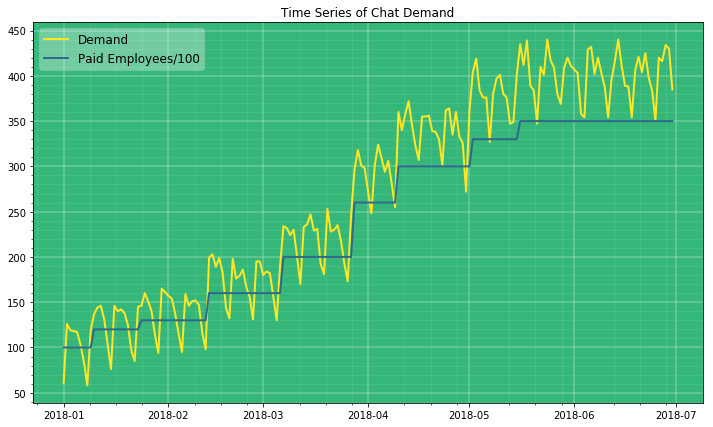

In [10]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dates, df['chats'], lw=2, color=viridis(9))
ax.plot(dates, df['paid_employees']/100, lw=2, color=viridis(3))
set_theme()
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title('Time Series of Chat Demand')
plt.legend(['Demand', 'Paid Employees/100'], framealpha=.3, fontsize='large')
plt.show()

We can see weekly seasonality (see below), and a growth month-over-month

Time series of the first two months of 2018

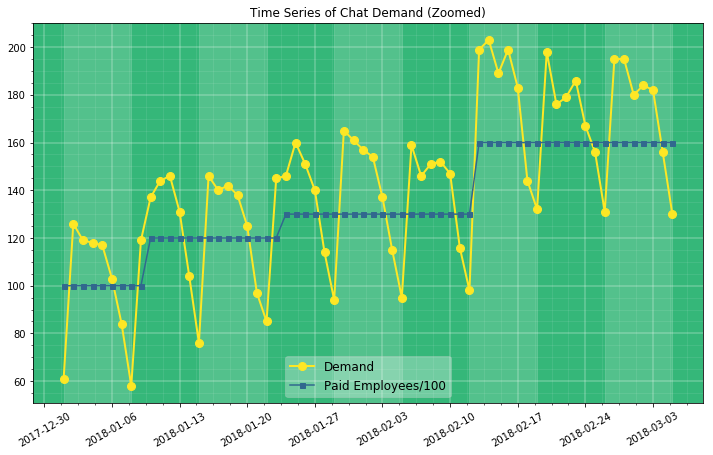

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dates[:64], df['chats'][:64], lw=2, color=viridis(9), marker='o', markersize=8)
ax.plot(dates[:64], df['paid_employees'][:64]/100, lw=1.5, color=viridis(3), marker='s', markersize=5)
set_theme()
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
[ax.axvspan(xmin=dates[i], 
            xmax=dates[i+7], alpha=0.15, 
            color='white') for i in range(0, 70, 14)]
plt.title('Time Series of Chat Demand (Zoomed)')
_ = plt.xticks(rotation=30)
plt.legend(['Demand', 'Paid Employees/100'], framealpha=.3, fontsize='large')
plt.show()

We can see weekly seasonality. It's halfway on Monday, doubles during the weekend, and drops in the weekend.

#### Advanced visualization

Getting the weekdays

In [12]:
day_of_week = pd.date_range('2018-01-01', '2018-06-30', freq='D').to_series()

In [13]:
weekday_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

In [14]:
df['weekday'] = day_of_week.dt.dayofweek.map(weekday_dict)
df.head()

,paid_employees,chats,weekday
date,,,
2018-01-01,10000,61,Monday
2018-01-02,10000,126,Tuesday
2018-01-03,10000,119,Wednesday
2018-01-04,10000,118,Thursday
2018-01-05,10000,117,Friday


Plotting the effect of the day of the week (mean)

In [15]:
weekday_effect = df.groupby('weekday')['chats'].mean()
weekday_effect.index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                       'Friday', 'Saturday', 'Sunday']

Plotting the effect of the day of the week (median)

In [16]:
weekday_effect_median = df.groupby('weekday')['chats'].median()
weekday_effect_median.index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                       'Friday', 'Saturday', 'Sunday']

Plotting the effect of the day of the week (sum)

In [17]:
weekday_effect_sum = df.groupby('weekday')['chats'].sum()
weekday_effect_sum.index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                       'Friday', 'Saturday', 'Sunday']

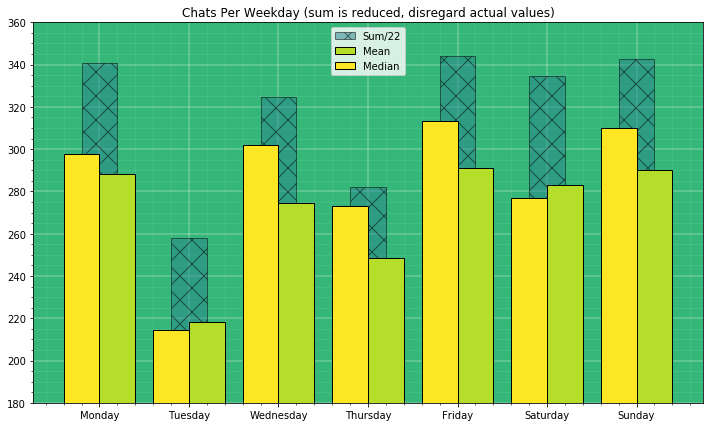

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(weekday_effect_sum.index, weekday_effect_sum/22, color=viridis(4), width=.4,
      linewidth=1, alpha=.5, hatch='x', edgecolor='k')
ax.bar(weekday_effect.index, weekday_effect, color=viridis(8), width=.4,
      edgecolor='k', linewidth=1, alpha=1, align='edge')
ax.bar(weekday_effect_median.index, weekday_effect_median, color=viridis(9), width=-.4,
      edgecolor='k', linewidth=1, alpha=1, align='edge')
set_theme()
ax.set_axisbelow(True)
plt.title('Chats Per Weekday (sum is reduced, disregard actual values)')
plt.legend(['Sum/22', 'Mean', 'Median'])
plt.ylim(180, 360)
plt.show()

Looking at the sum, median, and mean, a pattern emerges: the chats are less frequent Tuesdays and Thursdays. <font color='red'>**Note:**</font> the sum is divided by 22, so the overall pattern can be compared to the mean and median. However, the y-axis doesn't represent actual values _for the sum_. 

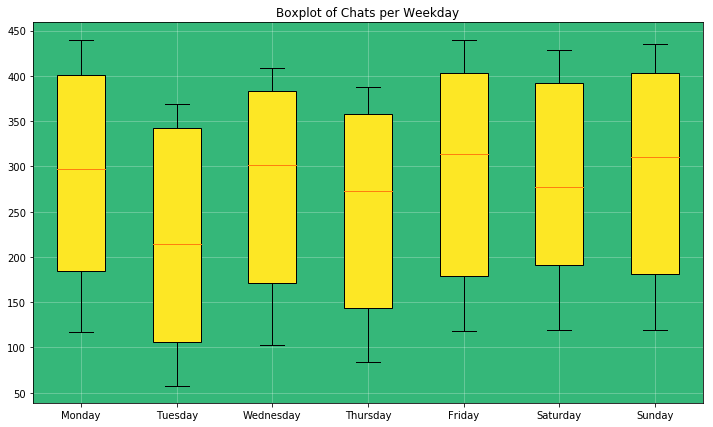

In [19]:
fig, ax = plt.subplots(figsize=(12, 7))
box = ax.boxplot(df.groupby('weekday')['chats'].apply(list), patch_artist=True)
ax.set_facecolor(viridis(6))
color=viridis(8)
for patch in box['boxes']:
    patch.set_facecolor(viridis(9))
ax.grid(True, alpha=0.3, color='white')
locs, labels = plt.xticks([1, 2, 3, 4, 5, 6, 7], 
                          ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                           'Friday', 'Saturday', 'Sunday'])
plt.title('Boxplot of Chats per Weekday')
plt.show()

## Preprocessing

Getting shifted  values up to two weeks ago

In [20]:
for i in range(1, 15):
    df.loc[:, 't–%s'%i] = df.loc[:, 'chats'].shift(i)

In [21]:
df.head()

,paid_employees,chats,weekday,t–1,t–2,t–3,t–4,t–5,t–6,t–7,t–8,t–9,t–10,t–11,t–12,t–13,t–14
date,,,,,,,,,,,,,,,,,
2018-01-01,10000,61,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,10000,126,Tuesday,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,10000,119,Wednesday,126.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,10000,118,Thursday,119.0,126.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,10000,117,Friday,118.0,119.0,126.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dealing with missing values

In [22]:
weekday_col = df['weekday']

In [23]:
df.drop('weekday', axis=1, inplace=True)

In [24]:
df = df.fillna(method='ffill', axis=1)
df.head()

,paid_employees,chats,t–1,t–2,t–3,t–4,t–5,t–6,t–7,t–8,t–9,t–10,t–11,t–12,t–13,t–14
date,,,,,,,,,,,,,,,,
2018-01-01,10000.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
2018-01-02,10000.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
2018-01-03,10000.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
2018-01-04,10000.0,118.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
2018-01-05,10000.0,117.0,118.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0


In [25]:
df['weekday'] = weekday_col

In [26]:
df.head()

,paid_employees,chats,t–1,t–2,t–3,t–4,t–5,t–6,t–7,t–8,t–9,t–10,t–11,t–12,t–13,t–14,weekday
date,,,,,,,,,,,,,,,,,
2018-01-01,10000.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,Monday
2018-01-02,10000.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,Tuesday
2018-01-03,10000.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,Wednesday
2018-01-04,10000.0,118.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,Thursday
2018-01-05,10000.0,117.0,118.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,Friday


Getting dummy variables for the weekday

In [27]:
day_dummies = pd.get_dummies(df.loc[:, 'weekday'].str.lower())

In [28]:
df = pd.concat([df, day_dummies], axis=1, sort=False)
df.drop('weekday', axis=1, inplace=True)

In [29]:
df.head()

,paid_employees,chats,t–1,t–2,t–3,t–4,t–5,t–6,t–7,t–8,...,t–12,t–13,t–14,friday,monday,saturday,sunday,thursday,tuesday,wednesday
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,10000.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,...,61.0,61.0,61.0,0,1,0,0,0,0,0
2018-01-02,10000.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,...,61.0,61.0,61.0,0,0,0,0,0,1,0
2018-01-03,10000.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,...,61.0,61.0,61.0,0,0,0,0,0,0,1
2018-01-04,10000.0,118.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,61.0,...,61.0,61.0,61.0,0,0,0,0,1,0,0
2018-01-05,10000.0,117.0,118.0,119.0,126.0,61.0,61.0,61.0,61.0,61.0,...,61.0,61.0,61.0,1,0,0,0,0,0,0


Casting dtype

In [30]:
df = df.astype(np.float64)

#### Splitting the data into train and test sets

Preprocessing and scaling `X`

In [31]:
X = df.drop(['chats', 'paid_employees'], axis=1).values

In [32]:
scaler = MinMaxScaler()

In [33]:
X = scaler.fit_transform(X)

`y`

In [34]:
y = df['chats']

In [35]:
dates[151:]

DatetimeIndex(['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04',
               '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08',
               '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12',
               '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16',
               '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20',
               '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24',
               '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28',
               '2018-06-29', '2018-06-30'],
              dtype='datetime64[ns]', freq='D')

In [36]:
X_train, X_test = X[:151], X[151:]

In [37]:
y_train, y_test = y[:151], y[151:]

### Forecasting

We will use the **mean absolute error** of chat number as the metric. We'll start by training a model, then we'll run it for the month of July. This is a good model because there is a strong seasonality, so values at time `t` are a function of values at time `t-h` (past values)

### Dense Neural Network 

Building the model

In [39]:
model = Sequential([
    Dense(16, input_shape=(X_train.shape[1],)),
    Dense(24, activation='relu'),
    Dense(48, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

Compiling the model

In [40]:
model.compile(optimizer='adam', loss='mae')

Callbacks

In [41]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint('dense.h5', monitor='val_loss', save_best_only=True)]

Training the model

In [43]:
_ = model.fit(X_train, y_train,
              epochs = 100, 
              batch_size = 8, 
              validation_data=[X_test, y_test],
              callbacks = callbacks,
              verbose=0)

Making predictions

In [44]:
#model = load_model('dense.h5')

In [45]:
y_pred = model.predict(X_test)

Evaluating predictions

In [46]:
mean_absolute_error(y_test, y_pred)

9.997186279296875

Plotting the predictions

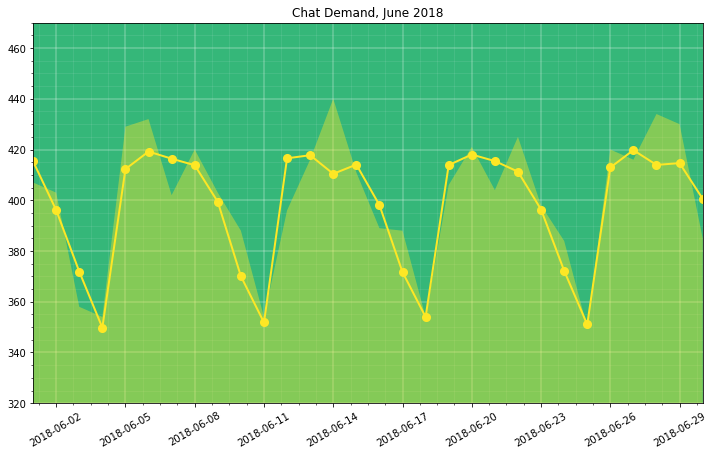

In [47]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.fill_between(dates[151:], 0, y_test, 
        lw=0, color=viridis(9), alpha=.4)
ax.scatter(dates[151:], y_pred, 
        lw=2, color=viridis(9), alpha=1, s=50)
ax.plot(dates[151:], y_pred, 
        lw=2, color=viridis(9), alpha=1)
ax.set_axisbelow(True)
plt.ylim(320, 470)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.xlim(dates[151], dates[-1])
plt.xticks(rotation=30)
set_theme()
plt.title('Chat Demand, June 2018')
plt.show()

### July prediction

In [48]:
pddf = pd.DataFrame(y_test[-28:][::-1])
for i in range(1, 15):
    pddf.loc[:, 't–%s'%i] = pddf.shift(-i)
pddf = np.hstack([pddf.values, pd.get_dummies(pd.to_datetime(pddf.index).dayofweek.map(weekday_dict))]) 

In [49]:
days_test = pd.date_range('7/1/2018', periods=31, freq='d')

In [51]:
predictions = []
for i in range(31):
    previous_pred = model.predict(scaler.transform(pddf[1, 1:].reshape(1, 21)))[0]
    t_minus_14 = pddf[0, 0:-8]
    dummies_day = pd.get_dummies(days_test.dayofweek.map(weekday_dict)).values[i, :]
    new_row = np.hstack([previous_pred, t_minus_14, dummies_day])
    pddf = np.vstack([new_row, pddf[:-1, :]])
    predictions.append(pddf[0, 0])

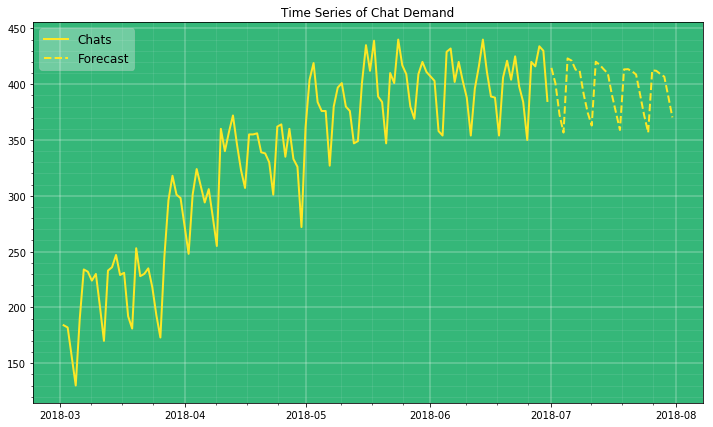

In [52]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dates[60:], df['chats'][60:], lw=2, color=viridis(9))
ax.plot(days_test, predictions, lw=2, color=viridis(9), linestyle='dashed', alpha=1)
set_theme()
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title('Time Series of Chat Demand')
plt.legend(['Chats', 'Forecast'], framealpha=.3, fontsize='large')
plt.show()

### Optimizing the number of nurses

In [55]:
from scipy.stats import mode
from sklearn.linear_model import LinearRegression

I will aggregate the number of chats per month, along with the needed nurses. Then, I will make a simple model to extrapolate the relationship between the two to the forecasted values of the month of July.

In [56]:
day_of_week = pd.date_range('2018-01-01', '2018-06-30', freq='D').to_series()
df['month'] = day_of_week.dt.month

Separating the aggregated values

In [57]:
y = df.groupby('month').apply(lambda x: mode(x)[0][0][0]).values

In [58]:
x = df.groupby('month').sum()['chats'].values

Running a simple model

In [59]:
reg = LinearRegression()

In [60]:
reg.fit(x.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Answer:

In [61]:
nurse_need = np.round(reg.predict(sum(predictions)), -3)
nurse_need

array([36000.])

Plotting the number of nurses

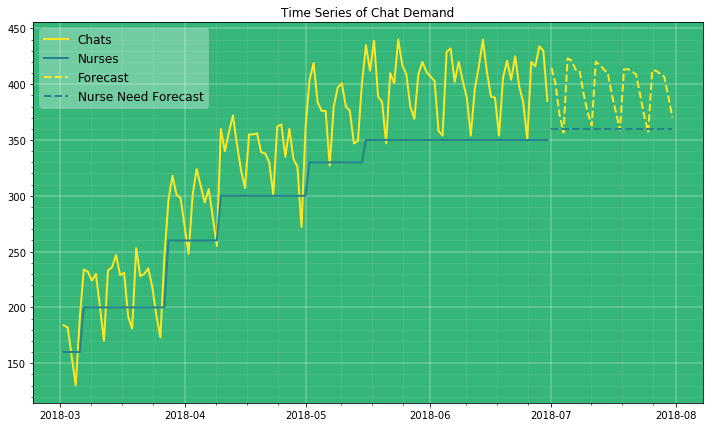

In [62]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(dates[60:], df['chats'][60:], lw=2, color=viridis(9))
ax.plot(dates[60:], df['paid_employees'][60:]/100, lw=2, color=viridis(4))
ax.plot(days_test, predictions, lw=2, color=viridis(9), linestyle='dashed', alpha=1)
ax.plot(days_test, [nurse_need/100 for i in range(len(days_test))], lw=2, color=viridis(4), linestyle='dashed')
set_theme()
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title('Time Series of Chat Demand')
plt.legend(['Chats', 'Nurses', 'Forecast', 'Nurse Need Forecast'], framealpha=.3, fontsize='large')
plt.show()

The actual values gave a number of nurses at the bottom of the lowest values at that month, multiplied by 100. The linear model replicated that relationship.

### Conclusion

Please include the code used to generate the forecast and an explanation of why you chose this method, including visualizations and/or summary statistics.

- Include an exploratory data analysis and report any finding on the dataset
>There is a strong weekly seasonality. 
- Provide a recommendation on the number of nurses needed per day in July
>36,000
- How would you evaluate the accuracy of your model?
>Here, with the MAE. In real life, I would like to obtain data on the waiting time of the clients (if the supply was adequate, etc)
- If the team starts using this model to staff the clinic, how would you evaluate the impact of this change?
>I would ideally look for improvement in customer satisfaction, but also waiting times, number of chats taken per nurse, the interval between chats, etc.
- What are the next steps to improve the model’s accuracy and its impact on costs and quality of service?
>This was based on a time series only. The next steps would be to use predictor variables, such as the number of customers. Also, we could take into account holidays, temperature, construction vacation weeks, and more. Alternatively, data that stretches further back in time would also help.